In [1]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [5]:
index = "dowjones"
# index = "frankfurt"
with open(f"../data/{index}_calculated/periods750_250_240.txt", "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

In [7]:
i = 7
timestep = 240
feature = 31

In [8]:
x_train = dataset[0][i][0].values
x_test = dataset[1][i][0].values

scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = to_categorical(dataset[0][i][1].values, 2)
y_test = to_categorical(dataset[1][i][1].values, 2)

In [9]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"x test shape: {x_test.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (750, 31)
y train shape: (750, 31, 2)
x test shape: (490, 31)
y test shape: (490, 31, 2)


In [10]:
x_series = [x_train[i:i+timestep, :] for i in range(x_train.shape[0] - timestep)]
y_series = [y_train[i+timestep] for i in range(y_train.shape[0] - timestep)]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (510, 240, 31)
y shape: (510, 31, 2)


In [11]:
x_series1 = [x_test[i:i+timestep, :] for i in range(x_test.shape[0] - timestep)]
y_series1 = [y_test[i+timestep] for i in range(y_test.shape[0] - timestep)]
x1 = np.array(x_series1)
y1 = np.array(y_series1)
print(f"x1 shape: {x1.shape}")
print(f"y1 shape: {y1.shape}")

x1 shape: (250, 240, 31)
y1 shape: (250, 31, 2)


In [12]:
regressor = Sequential()
regressor.add(LSTM(units=25, input_shape=(timestep, feature)))
regressor.add(Dense(feature * 2, activation='relu'))
regressor.add(Reshape((feature, 2)))
# regressor.add(Lambda(lambda x: softmax(x, axis=-1)))
regressor.add(Dense(2, activation='softmax'))
regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                5700      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                1612      
_________________________________________________________________
reshape_1 (Reshape)          (None, 31, 2)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 31, 2)             6         
Total params: 7,318
Trainable params: 7,318
Non-trainable params: 0
_________________________________________________________________


In [13]:
# result = regressor.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=1000)
result = regressor.fit(x, y, epochs=1000, validation_data=(x1, y1), callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=50),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', save_best_only=True)])

Train on 510 samples, validate on 250 samples
Epoch 1/1000
510/510 [==============================] - 4s 8ms/step - loss: 0.6933 - acc: 0.5079 - val_loss: 0.6932 - val_acc: 0.5086
Epoch 2/1000
510/510 [==============================] - 3s 6ms/step - loss: 0.6915 - acc: 0.5233 - val_loss: 0.6931 - val_acc: 0.5080
Epoch 3/1000
510/510 [==============================] - 3s 6ms/step - loss: 0.6904 - acc: 0.5274 - val_loss: 0.6931 - val_acc: 0.5079
Epoch 4/1000
510/510 [==============================] - 3s 6ms/step - loss: 0.6894 - acc: 0.5379 - val_loss: 0.6932 - val_acc: 0.5085
Epoch 5/1000
510/510 [==============================] - 3s 6ms/step - loss: 0.6884 - acc: 0.5448 - val_loss: 0.6934 - val_acc: 0.5054
Epoch 6/1000
510/510 [==============================] - 3s 7ms/step - loss: 0.6874 - acc: 0.5491 - val_loss: 0.6936 - val_acc: 0.5053
Epoch 7/1000
510/510 [==============================] - 3s 6ms/step - loss: 0.6863 - acc: 0.5561 - val_loss: 0.6938 - val_acc: 0.5036
Epoch 8/1000
510

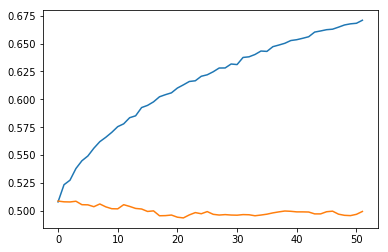

In [14]:
plt.plot(result.history["acc"])
plt.plot(result.history["val_acc"])

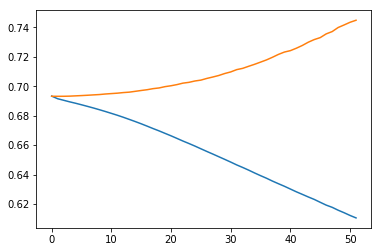

In [15]:
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])